In [10]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

sns.set_theme()
sns.set_context(font_scale=1.5)

In [20]:
df = pd.read_csv('../data/data.csv')

# remove informações que não são extraídas dos sinais de vibração
df.pop('rotacao_manual')
df.pop('severidade')

# exibe lista de características
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 880 entries, 0 to 879
Columns: 119 entries, condicao to tg2_freqstat_rvf
dtypes: float64(118), object(1)
memory usage: 818.2+ KB


In [21]:
# exibe porção dos dados
df.head()

,condicao,rotacao_calc,ax1_1h,ax2_1h,rad1_1h,rad2_1h,tg1_1h,tg2_1h,freq_ax_1h,ax1_2h,...,rad1_freqstat_rmsf,rad2_freqstat_rmsf,tg1_freqstat_rmsf,tg2_freqstat_rmsf,ax1_freqstat_rvf,ax2_freqstat_rvf,rad1_freqstat_rvf,rad2_freqstat_rvf,tg1_freqstat_rvf,tg2_freqstat_rvf
0,horizontal-misalignment,12.0,12.449576,34.974786,1.052121,3.037683,0.461724,8.995064,12.4,1.259489,...,7.958972,4.821183,5.017223,6.206503,51169.761355,17249.428380,114800.772907,69928.475186,252622.928376,60630.713653
1,horizontal-misalignment,13.2,12.766118,35.883819,1.622110,1.712058,0.346181,9.474440,13.6,0.988185,...,8.765322,4.654980,5.505516,6.403507,68464.121323,26401.575860,131974.345460,167007.385207,270909.216318,80942.428866
2,horizontal-misalignment,14.2,14.641137,42.621094,1.595115,1.987015,0.252124,11.127159,14.6,0.608318,...,9.120809,4.745813,6.004309,6.752436,75062.917500,28635.127881,139877.969129,175138.166742,272413.709048,93671.422798
3,horizontal-misalignment,15.0,11.691759,41.273426,1.367533,1.996131,0.151894,9.787049,15.4,0.109013,...,9.103099,4.659249,6.112037,6.608452,81908.174839,26817.457380,137105.614797,166868.806959,260909.615054,92841.390546
4,horizontal-misalignment,16.0,11.575027,47.248436,1.184740,2.462926,0.076388,11.191638,16.4,0.527295,...,9.885235,4.754959,6.712735,7.281942,88637.175263,30672.520669,143400.474219,170506.559874,263438.425567,102018.166261


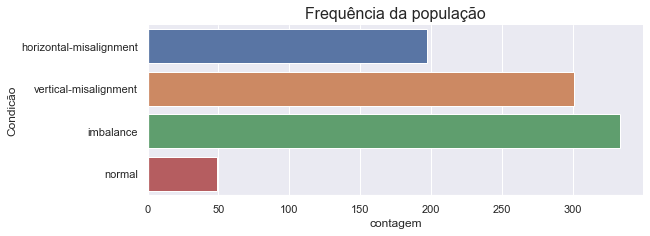

In [22]:
# plota distribuição da população
sns.catplot(data=df, y='condicao', kind="count", height=3, aspect=3)
plt.title('Frequência da população', fontsize=16)
plt.ylabel('Condicão')
plt.xlabel('contagem')
plt.show()

In [23]:
output_map = {
    'normal': 0,
    'imbalance': 1,
    'vertical-misalignment': 2,
    'horizontal-misalignment': 3,
}

# armazena output em um array
labels = np.array(df['condicao'].map(output_map))

# remove a coluna de labels do df original
df = df.drop('condicao', axis = 1)

# Modelos

In [24]:
columns = list(df.columns)

feat_type = {
    'harmonico 1': [col for col in columns if '1h'    in col],
    'harmonico 2': [col for col in columns if '2h'    in col],
    'harmonico 3': [col for col in columns if '3h'    in col],
    'harmonicos':  [col for col in columns if '1h' in col or '2h' in col or '3h' in col],
    'entropia':    [col for col in columns if 'entr'  in col],
    'curtose':     [col for col in columns if 'kurt'  in col],
    'RMS':         [col for col in columns if 'rms'   in col],
    'estat_tempo': [col for col in columns if 'timestat'  in col],
    'estat_freq':  [col for col in columns if 'freqstat'  in col],
    'estatisticos':[col for col in columns if 'stat'  in col],
    'fase':        [col for col in columns if 'phase' in col],
}

feature_models = {
    ('Espectro', 'Harmônicas'): 
        sorted(list(set().union(['rotacao_calc'], feat_type['harmonicos']))),
    ('Espectro', 'Ângulos de fase'):
        sorted(list(set().union(['rotacao_calc'], feat_type['fase']))),
    ('Espectro', 'Harmônicas e fase'):
        sorted(list(set().union(['rotacao_calc'],  feat_type['harmonicos'],  feat_type['fase']))),
    ('Estatístico', 'RMS'):
        sorted(list(set().union(['rotacao_calc'], feat_type['RMS']))),
    ('Estatístico', 'Entropia e curtose'):
        sorted(list(set().union(['rotacao_calc'], feat_type['entropia'], feat_type['curtose']))),
    ('Estatístico', 'Estatísticas no tempo'):
        sorted(list(set().union(['rotacao_calc'], feat_type['estat_tempo'],))),
    ('Estatístico', 'Estatísticas na frequência'):
        sorted(list(set().union(['rotacao_calc'], feat_type['estat_freq'],))),
    ('Estatístico', 'Estatísticas geral'):
        sorted(list(set().union(['rotacao_calc'], feat_type['estatisticos'],))),
    ('', 'Todas'):
        df.columns
}

feature_models_data = {k: df[v] for k, v in feature_models.items() }

for k, v in feature_models_data.items():
    print(f'{k[1]} com {v.shape[1]} características')

Harmônicas com 22 características
Ângulos de fase com 7 características
Harmônicas e fase com 28 características
RMS com 13 características
Entropia e curtose com 19 características
Estatísticas no tempo com 73 características
Estatísticas na frequência com 19 características
Estatísticas geral com 91 características
Todas com 118 características


In [25]:
from sklearn.model_selection import KFold, cross_val_score, cross_val_predict, GroupKFold, StratifiedKFold, cross_validate

kfold = StratifiedKFold(n_splits=8, shuffle=True, random_state=42)

In [26]:
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC

acc_mean = []
acc_std = []
roc_mean = []
roc_std = []

clf = make_pipeline(StandardScaler(), SVC(kernel='linear'))

for k, v in feature_models_data.items():
    model = clf
    evaluation = cross_validate(
        estimator= model,
        X=v.values, y=labels,
        cv=kfold,
        scoring=['accuracy'])
    
    acc_mean.append(evaluation['test_accuracy'].mean())
    acc_std.append(evaluation['test_accuracy'].std())

In [27]:
index = pd.MultiIndex.from_tuples(feature_models.keys(), names=['Tipo', 'Características'])
results = pd.DataFrame({
    'Acurácia': [f'{m:.3f} ± {s:.3f}'.replace('.',',') for m, s in zip(acc_mean, acc_std)],
    }, index=index)

print(results.to_latex())
results

\begin{tabular}{lll}
\toprule
            &       &       Acurácia \\
Tipo & Características &                \\
\midrule
Espectro & Harmônicas &  0,960 ± 0,019 \\
            & Ângulos de fase &  0,759 ± 0,021 \\
            & Harmônicas e fase &  0,970 ± 0,016 \\
Estatístico & RMS &  0,933 ± 0,019 \\
            & Entropia e curtose &  0,852 ± 0,024 \\
            & Estatísticas no tempo &  0,959 ± 0,020 \\
            & Estatísticas na frequência &  0,964 ± 0,008 \\
            & Estatísticas geral &  0,990 ± 0,013 \\
            & Todas &  0,990 ± 0,008 \\
\bottomrule
\end{tabular}



Acurácia
Tipo        Características                          
Espectro    Harmônicas                  0,960 ± 0,019
            Ângulos de fase             0,759 ± 0,021
            Harmônicas e fase           0,970 ± 0,016
Estatístico RMS                         0,933 ± 0,019
            Entropia e curtose          0,852 ± 0,024
            Estatísticas no tempo       0,959 ± 0,020
            Estatísticas na frequência  0,964 ± 0,008
            Estatísticas geral          0,990 ± 0,013
            Todas                       0,990 ± 0,008

## Seleção de características

In [ ]:
from sklearn.feature_selection import SequentialFeatureSelector

min_features_to_select = 1  # Minimum number of features to consider
svc = SVC(kernel='linear')

sfs = SequentialFeatureSelector(estimator=svc, cv=kfold,
              scoring='accuracy')
sfs.fit(df, labels)

In [ ]:
plt.figure()
plt.xlabel("Numero de características selecionadas")
plt.ylabel("Acurácia de validação cruzada")
plt.plot(range(min_features_to_select,
         len(sfs.grid_scores_) + min_features_to_select),
         sfs.grid_scores_)
plt.show()

In [ ]:
list(df.columns[sfs.support_])

### Train-Test split

In [21]:
from sklearn.model_selection import train_test_split

# separa os conjuntos de treino e teste com amostragem estratificada,
# logo, mantendo a proporção para cada tipo de defeito
X_train, X_test, y_train, y_test = train_test_split(df, labels, test_size = 0.25, stratify=labels, random_state=42) 

model.fit(X_train, y_train)
y_predicted = model.predict(X_test)

In [22]:
from sklearn.metrics import confusion_matrix

confusion_matrix(y_test, y_predicted)

array([[12,  0,  0,  0],
       [ 0, 82,  1,  0],
       [ 1,  1, 72,  2],
       [ 5,  0,  0, 44]], dtype=int64)